# Simple estimation of the primary beam model

This exmaple shows how to generate a catalog of sources and generate a primary beam model gridded onto a 2D grid using these measurements.

In [1]:
%matplotlib notebook
import numpy as np
import pickle
import pylab
import beam_solver as bs
from beam_solver.data import DATA_PATH
import healpy
import os

## Generate source catalog

We define the positions (right ascension and declination values) and extract flux measurments which is stored as catData object in the form of the source catalog. The catData object consists of data and necessary metadata. This can be computationaly expensive depending on the number of positions and fitsfiles.

In [2]:
# right ascension and declination values
ras = [30.02154061, 27.72922349, 36.75248962, 34.241549]
decs = [-30.88345344, -29.53377208, -30.63958257, -29.93990039]

# fitsfiles
fits1 = os.path.join(DATA_PATH, '2458115.23736.xx.fits')
fits2 = os.path.join(DATA_PATH, '2458115.24482.xx.fits')
fitsfiles = [fits1, fits2]

# generate source catalog
cat = bs.gencat.genCatBase(fits=fitsfiles, ras=ras, decs=decs)
srcd = cat.gen_catalog()

Found 4 unique sources out of 4.


In [3]:
print ('Number of sources: {}'.format(srcd.Nsrcs))
print ('Number of fitsfiles: {}'.format(srcd.Nfits))
print ('Peak measurement: {}'.format (srcd.pflux_array))

Number of sources: 4
Number of fitsfiles: 2
Peak measurement: [[[ 9.16360855 14.10211372]
  [14.54778671 16.49849701]
  [ 0.23727688  0.87325466]
  [ 0.75241214  1.67068756]]]


## Calculate corrected flux values

Here we calculate the corrected flux values using
\begin{equation}
I = \frac{\sum^t I_0(t, \nu) A(t, \nu)}{\sum_t A(t, \nu)^2}
\end{equation}
where $I_0$ are the flux measurements and $A$ is the primary beam value at time t and frequency $\nu$.

<IPython.core.display.Javascript object>


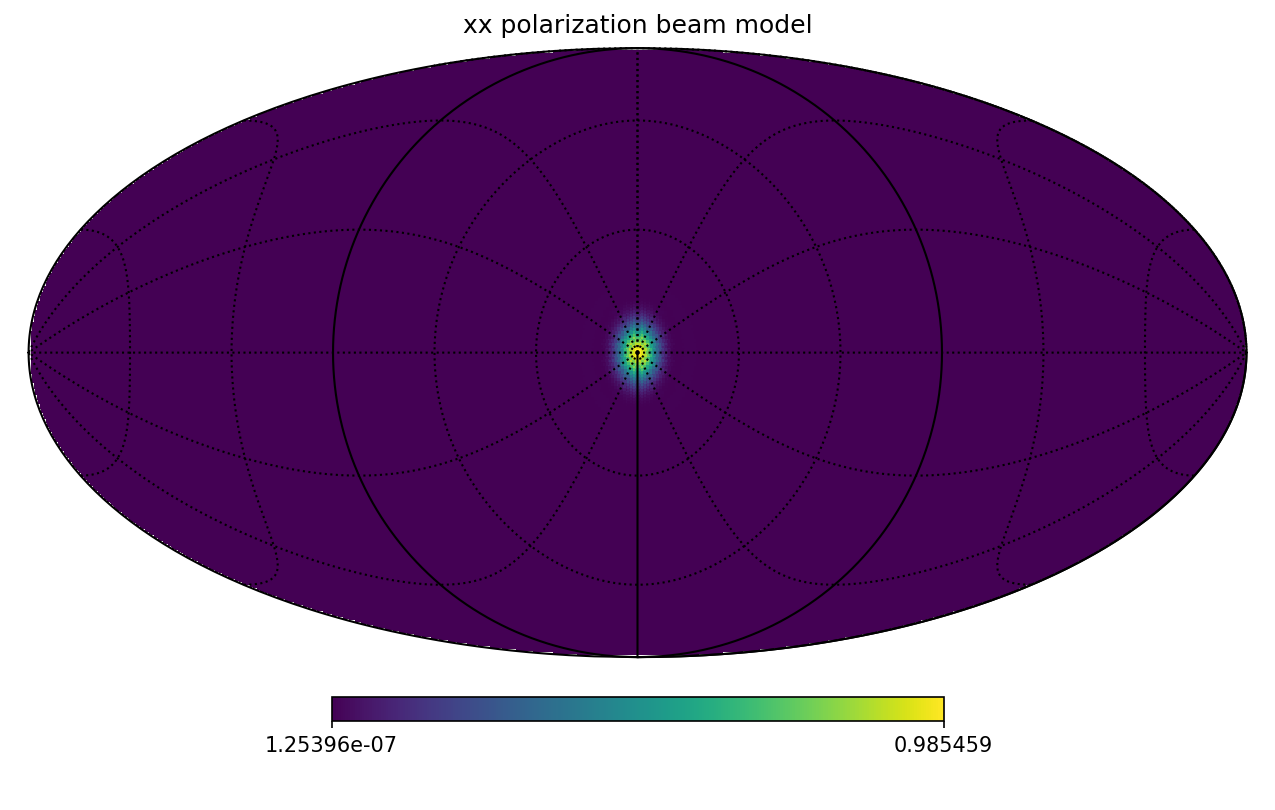

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [4]:
# calculating corrected flux values

# select the beam files
bfile1 = os.path.join(DATA_PATH, 'HERA_4.9m_E-pattern_151MHz.txt')
bfile2 = os.path.join(DATA_PATH, 'HERA_4.9m_E-pattern_152MHz.txt')

#generating beam model at 151.5 MHz and xx polarization
bm = bs.catbeam.catBeamCst()
beam = bm.generate_beam([bfile1, bfile2], [151, 152], 151.5)

# plotting beam model
healpy.mollview(beam['data']['xx'], rot=[0, 90], title='xx polarization beam model')
healpy.graticule()

In [5]:
srcd.calc_corrflux(beam=beam)

corrfluxs = srcd.pcorr_array
print ('Corrected flux values: {}'.format(corrfluxs[0]))

Corrected flux values: [17.88454083 18.3064043  11.02740234  6.43189937]


## Saving the file as a h5py file 

We can save the catData object as a h5py file and read it again whenever when required.

In [6]:
# saving catalog to h5py file
srcd.write_hdf5('srcd.h5', clobber=True)

Overwriting existing file.


## Solving for primary beam using measurements

We construct a system of linear equations using the four closest points to the source position ($\alpha$, $\delta$):

\begin{align}
I_0 &= AI^M \\
    &= (b_0w_0 + b_1w_1 + b_2w_2 + b_3w_3)I^M
\end{align}

where ($b_0$, $b_1$, $b_2$, $b_3$) are the beam values and ($w_0$, $w_1$, $w_2$, $w_3$) are the corresponding weights allocated to the corresponding pixels. ($b_0$, $b_1$, $b_2$, $b_3$) are the unknowns we are solving for.

In [7]:
# solve for unknown parameters
bms= bs.beamsolve.BeamSolveBase(srcd)
bms.construct_linear_sys(flux_type='peak')
sol = bms.solve(solver='Linear')

print ('Solutions returned by solver: {}'.format(sol))

Solving 0/1
Time Elapsed: 0.01 seconds
Solutions returned by solver: {'b2009': 0.47965893012806743, 'b2189': 0.001581137273947329, 'b2129': 0.07164644185792568, 'b2131': 0.05603833863826968, 'b2130': 0.10254383660645172, 'b2010': 0.4705063490740887, 'b2011': -0.048447892956298394, 'b2070': 0.11816313226737866, 'b2071': 0.1414491302238694, 'b2190': 0.0019722836104745702, 'b1889': 0.045929940914150987, 'b1950': 0.8698018256472779, 'b1951': 0.5077794495822259, 'b1831': 0.25484450005937065, 'b1830': 0.5287674673349851, 'b1949': 0.7747673307257342, 'b2069': 0.008578721111221236, 'b1891': 0.7878126651946258, 'b1890': 1.3014754480575872}


## Evaluating the solutions into a 2D grid 

We evaluate the solutions returned by the linsolve which is the form of a dictionary to construct the 2D primary beam.

<IPython.core.display.Javascript object>


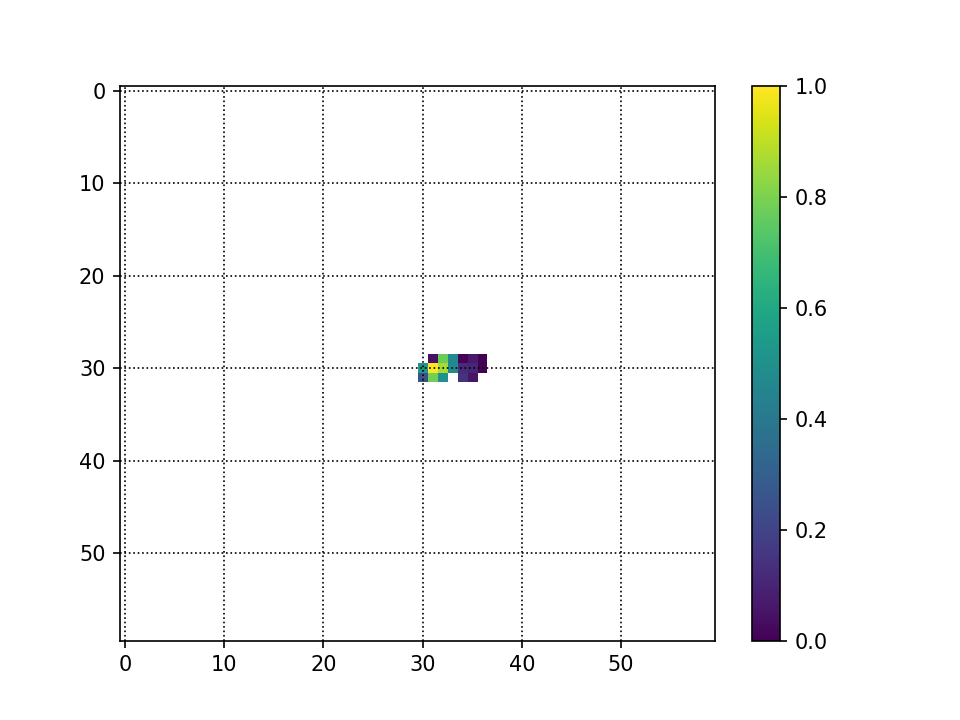

In [8]:
# evaluation beam solutions
obsbeam = bms.eval_sol(sol)

pylab.imshow(obsbeam.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
pylab.grid(ls='dotted', color='black')
pylab.colorbar()

## Removing degenarate modes 

There are few degenerate modes which are due to the limited number of equation involved with certain unknowns. We therefore try to remove those degenerate modes using single value decomposition.

Removing all eigen modes above 8


<IPython.core.display.Javascript object>


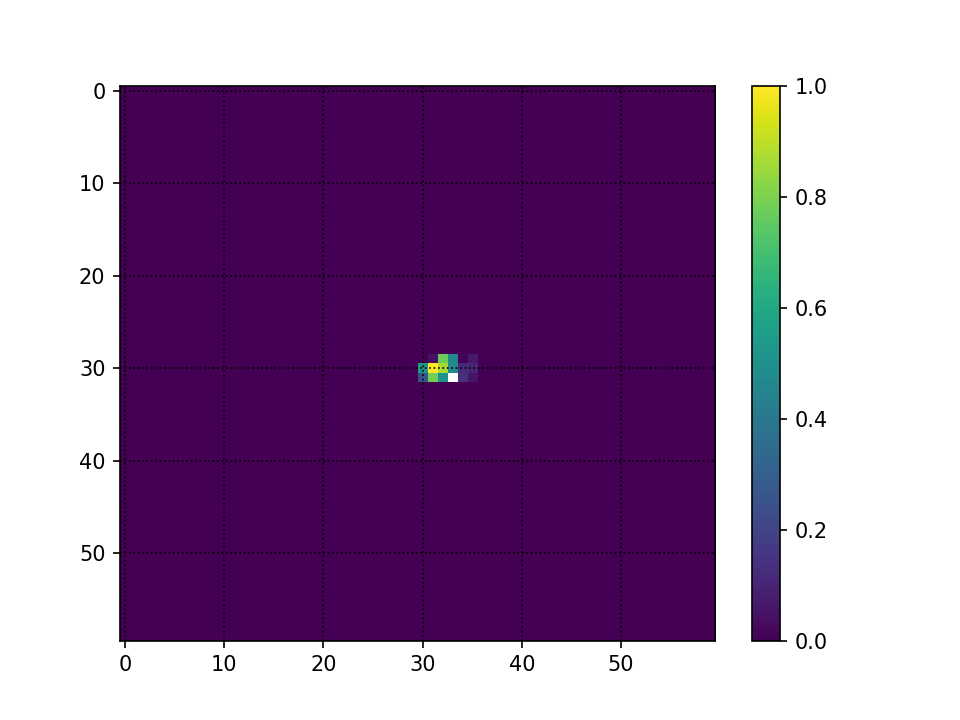

In [9]:
# remove degeneracies
obsbeam = bms.remove_degen(sol, threshold=0.003)
pylab.imshow(obsbeam.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
pylab.grid(ls='dotted', color='black')
pylab.colorbar()